In [ ]:
pip install lux

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import lux
import gc
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from google.colab import output
output.enable_custom_widget_manager()
from sklearn.feature_selection import RFECV

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/file/E_02-22-2018.csv.csv")

In [ ]:
df

/usr/local/lib/python3.9/dist-packages/lux/executor/PandasExecutor.py:448: UserWarning:
Lux detects that the attribute 'Timestamp' may be temporal.
To display visualizations for these attributes accurately, please convert temporal attributes to Datetime objects.
For example, you can convert a Year attribute (e.g., 1998, 1971, 1982) using pd.to_datetime by specifying the `format` as '%Y'.

Here is a starter template that you can use for converting the temporal fields:
	df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='<replace-with-datetime-format>')

See more at: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
If Timestamp is not a temporal attribute, please use override Lux's automatically detected type:
	df.set_data_type({'Timestamp':'quantitative'})
/usr/local/lib/python3.9/dist-packages/lux/interestingness/interestingness.py:166: UserWarning:An error occurred when computing interestingness for: <Vis  (x: Flow IAT Mean, y: Tot Bwd Pkts) mar

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month

In [ ]:
df = df.drop('Timestamp', axis=1)

In [ ]:
X = df.loc[:, ~df.columns.isin(['Label'])]

In [ ]:
y = df.loc[:,"Label"].values

In [ ]:
corrr = pd.DataFrame(X).corr()

In [ ]:
# select columns with correlation higher than 0.5
high_corr_cols = np.where(corrr > 0.5)
high_corr_cols = [(corrr.index[x], corrr.columns[y]) for x, y in zip(*high_corr_cols) if x != y]

In [ ]:
# drop the columns with low correlation
low_corr_cols = set(X.columns) - set(list(zip(*high_corr_cols))[0])
X = X.drop(low_corr_cols, axis=1)

In [ ]:
import numpy as np

# Assuming X is your input data
# Replace infinite values with a large number
X[X == np.inf] = np.finfo('float64').max

# Replace too large values with NaN
X[np.abs(X) > np.finfo('float64').max] = np.nan

# Remove rows with NaN values
X = X[~np.isnan(X).any(axis=1)]

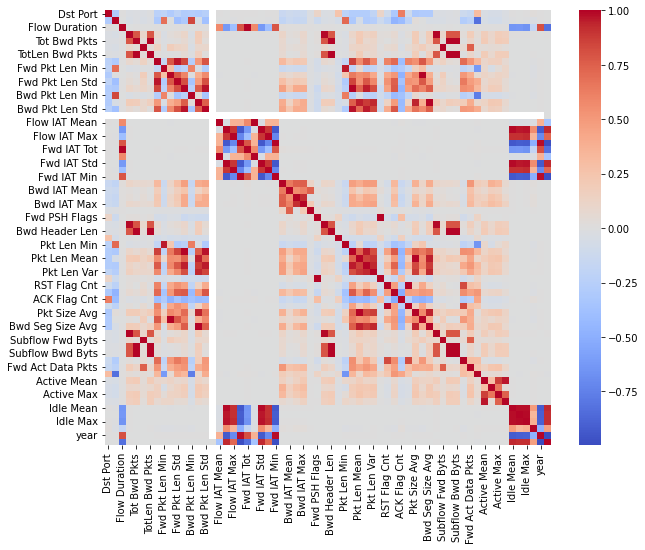

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X.corr()
plt.figure(figsize=(10,8))
# Plot the heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

# Show the plot
plt.show()


In [ ]:
# import numpy as np

# # Assuming X is your input data
# # Replace infinite values with a large number
# X[X == np.inf] = np.finfo('float64').max

# # Replace too large values with NaN
# X[np.abs(X) > np.finfo('float64').max] = np.nan

# # Remove rows with NaN values
# X = X[~np.isnan(X).any(axis=1)]


In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=42)


In [ ]:
# from sklearn.decomposition import NMF

# # create an instance of the NMF model with 10 components
# nmf_model = NMF(n_components=10, init='random', random_state=42)

# # fit the model to the training data
# W_train = nmf_model.fit_transform(X_train)

# # print the shape of the W_train matrix
# print(W_train.shape)


In [ ]:
# apply PCA to reduce dimensionality of feature space
pca = PCA(n_components=14)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
train_pca_df = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(14)])
test_pca_df = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(14)])

In [ ]:
train_pca_df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
test_pca_df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
iso = IsolationForest(random_state=42)
iso.fit(X_train_pca)
iso.fit(X_test_pca)
X_train_iso = iso.predict(X_train_pca)
X_test_iso = iso.predict(X_test_pca)
df_train_iso = pd.DataFrame({'IsolationForest': X_train_iso})
df_test_iso = pd.DataFrame({'IsolationForest': X_test_iso})

In [ ]:
df_train_iso

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
df_test_iso 

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
train_acc = (df_train_iso['IsolationForest'] == 1).sum() / len(df_train_iso)
test_acc = (df_test_iso['IsolationForest'] == 1).sum() / len(df_test_iso)

In [ ]:
train_acc

0.8998068807667549

In [ ]:
test_acc

0.8989676465679612

In [ ]:
# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LogisticRegression

# Create a logistic regression object
lr = LogisticRegression(random_state=42)

# Create a recursive feature elimination object
rfe = RFECV(estimator=lr, cv=5)
# Fit the RFE object on the PCA transformed training data
rfe.fit(X_train_pca, y_train)



KeyboardInterrupt: ignored

In [ ]:
# Get the selected features
selected_features = train_pca_df.columns[rfe.support_]

# Transform the training and test datasets with selected features
X_train_rfe = train_pca_df[selected_features]
X_test_rfe = test_pca_df[selected_features]

In [ ]:
# apply RFE to select most relevant features
# apply backward feature selection on the PCA
rfe = RFE(estimator=LogisticRegression(random_state=42,multi_class="multinomial"),n_features_to_select=14,)
X_train_rfe = rfe.fit_transform(X_train_pca, y_train)
X_test_rfe = rfe.transform(X_test_pca)

In [ ]:
train_RFE_df = pd.DataFrame(X_train_rfe, columns=[f"rfe{i+1}" for i in range(14)])
test_Rfe_df = pd.DataFrame(X_test_rfe, columns=[f"rfe{i+1}" for i in range(14)])

In [ ]:
train_RFE_df = pd.DataFrame(X_train_rfe)
test_Rfe_df = pd.DataFrame(X_test_rfe)

In [ ]:
train_RFE_df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
test_Rfe_df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
iso = IsolationForest(random_state=42)
iso.fit(X_train_rfe)
X_train_iso = iso.predict(X_train_rfe)
X_test_iso = iso.predict(X_test_rfe)
df_train_iso = pd.DataFrame({'IsolationForest': X_train_iso})
df_test_iso = pd.DataFrame({'IsolationForest': X_test_iso})

In [ ]:
train_acc = (df_train_iso['IsolationForest'] == 1).sum() / len(df_train_iso)
test_acc = (df_test_iso['IsolationForest'] == 1).sum() / len(df_test_iso)

In [ ]:
test_acc

In [ ]:
train_acc

In [ ]:
# Combine original features with IsolationForest results
X_train_combined = np.column_stack((X_train_rfe, X_train_iso))
X_test_combined = np.column_stack((X_test_rfe, X_test_iso))

# Train logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train_combined, y_train)

# Evaluate accuracy on training and test sets
train_acc = lr.score(X_train_combined, y_train)
test_acc = lr.score(X_test_combined, y_test)

print("Training accuracy:", train_acc)
print("Test accuracy:", test_acc)


In [ ]:

# Create a DataFrame for the combined training data
train_df = pd.DataFrame(X_train_combined)

# Create a DataFrame for the combined testing data
test_df = pd.DataFrame(X_test_combined)

In [ ]:
# Calculate the correlation matrix for the train data
corr_train = train_df.corr()

# Calculate the correlation matrix for the test data
corr_test = test_df.corr()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

# Create a heatmap for the train data correlation matrix
sns.heatmap(corr_train, ax=ax1)
ax1.set_title('Train Data Correlation Matrix')

# Create a heatmap for the test data correlation matrix
sns.heatmap(corr_test, ax=ax2)
ax2.set_title('Test Data Correlation Matrix')

# Show the plot
plt.show()

In [ ]:
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.512955,0.531165,-0.558414,0.037379,0.095728,-0.028075,-0.033240,0.059993,0.004110,-0.036152,0.000839,-0.010877,-0.012385,-0.001079,1.0
1,-0.309697,-0.629726,-0.320951,0.024410,0.022276,0.022719,-0.018338,-0.027819,-0.020661,-0.014150,-0.000041,-0.003132,0.000481,0.000582,1.0
2,0.885967,0.050011,0.266067,-0.054861,-0.177084,0.174360,0.578531,-0.388236,0.011112,-0.038688,0.001259,0.000589,0.021445,0.003434,1.0
3,-0.308571,-0.629810,-0.319401,0.024685,0.024791,0.022992,-0.016242,-0.025476,-0.020002,-0.013151,0.000205,-0.008274,-0.006988,-0.000989,1.0
4,1.521896,0.530990,-0.549514,0.042019,0.114641,-0.026168,-0.022169,0.064357,0.005977,-0.033621,0.000601,-0.013309,0.001354,0.000362,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838855,-0.728536,0.520194,0.030937,-0.180161,0.030813,-0.060100,0.013331,0.020316,-0.015227,-0.001446,-0.009019,-0.003508,0.000834,-0.016386,1.0
838856,-0.663034,0.386312,0.027503,-0.075132,-0.038251,-0.416596,0.091421,0.032161,-0.023725,-0.002492,0.012474,-0.005146,0.000202,0.011690,1.0
838857,-0.298143,-0.634876,-0.310431,0.030924,0.050143,0.029729,0.008649,-0.001590,-0.017936,0.000670,-0.000101,0.000607,-0.001004,0.000175,1.0
838858,-0.663031,0.386307,0.027502,-0.075134,-0.038251,-0.416612,0.091426,0.032160,-0.023728,-0.002492,0.012503,-0.005141,0.000240,0.011352,1.0


In [ ]:
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.792516,0.649505,0.034861,-0.272515,0.094717,0.288646,-0.064613,0.010195,-0.002847,-0.001075,-0.070835,-0.008731,-0.053683,0.457608,-1.0
1,-0.766339,0.590949,0.094775,1.257180,-0.271995,-0.085771,0.042739,0.024283,-0.007664,-0.000941,-0.034155,-0.005944,-0.009955,-0.025947,1.0
2,-0.309099,-0.629492,-0.319778,0.024320,0.023482,0.022601,-0.017578,-0.026712,-0.020048,-0.013912,0.000242,-0.009512,-0.008358,-0.001096,1.0
3,-0.313307,-0.627547,-0.323449,0.021903,0.013482,0.019819,-0.027937,-0.036858,-0.021034,-0.019805,0.000327,-0.012210,-0.008878,-0.001445,1.0
4,0.432632,-0.202948,0.482260,-0.087885,-0.361119,0.025566,-0.072722,0.114504,-0.033278,-0.029229,-0.000742,-0.000474,-0.005898,-0.001007,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209710,0.393254,-0.200868,0.447526,-0.102667,-0.430306,0.010494,-0.140218,0.061561,-0.042726,0.005966,-0.001706,0.027068,0.018720,0.001516,1.0
209711,-0.675092,0.410971,0.028130,-0.094565,-0.025503,-0.350979,0.077063,0.029966,-0.022200,-0.002293,0.008914,-0.004778,0.000854,0.001650,1.0
209712,-0.294290,-0.635985,-0.306155,0.032591,0.059178,0.031516,0.016904,0.006884,-0.016444,0.005001,0.000179,-0.005981,-0.011994,-0.001467,1.0
209713,-0.299852,-0.633966,-0.311799,0.029827,0.045944,0.028531,0.004463,-0.005552,-0.018199,-0.001685,0.000019,-0.001942,-0.003417,-0.000553,1.0


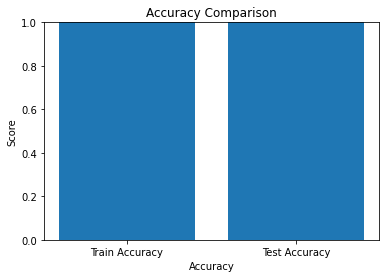

In [ ]:
import matplotlib.pyplot as plt

# Calculate train and test accuracy
train_acc = lr.score(X_train_combined, y_train)
test_acc = lr.score(X_test_combined, y_test)

# Plot a bar graph
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc])
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# Predict the labels for the train and test sets
y_train_pred = lr.predict(X_train_combined)
y_test_pred = lr.predict(X_test_combined)

# Calculate the F1 score for train set
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Calculate the F1 score for test set
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Print the F1 score for train and test sets
print("Train F1 score: {:.12f}".format(f1_train))
print("Test F1 score: {:.12f}".format(f1_test))


Train F1 score: 0.999690517039
Test F1 score: 0.999668570245


In [ ]:


# # Create a bar plot of the accuracy
# plt.bar(['Training', 'Test'], [train_acc, test_acc])
# plt.ylabel('Accuracy')
# plt.title('Logistic Regression Model Accuracy')
# plt.show()


In [ ]:

# logreg = LogisticRegression(random_state=42)

# Fit the model to the training data
lr.fit(X_train_rfe, y_train)
# logreg.fit(X_test_rfe, y_test)

# Make predictions on the training and test data
y_train_pred = lr.predict(X_train_rfe)
y_test_pred = lr.predict(X_test_rfe)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print("Training accuracy: {:.12f}%".format(train_accuracy*100))
print("Test accuracy: {:.12f}%".format(test_accuracy*100))

Training accuracy: 99.975800491143%
Test accuracy: 99.974727606514%


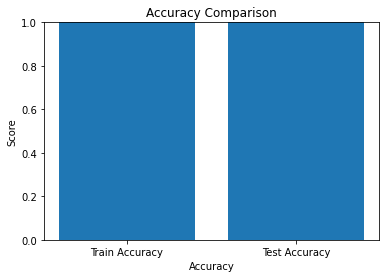

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Create a bar plot
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy])
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Score')
plt.ylim(0, 1) # set the y-axis limit from 0 to 1
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score for train set
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Calculate the F1 score for test set
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Print the F1 score for train and test set
print("Train F1 score: {:.12f}".format(f1_train))
print("Test F1 score: {:.12f}".format(f1_test))


Train F1 score: 0.999690517039
Test F1 score: 0.999670648768


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot histogram of y_train
# sns.set(style='whitegrid')
# plt.hist(y_train, alpha=0.5, color='blue', label='y_train')
# plt.hist(y_train_pred, alpha=0.5, color='red', label='y_train_pred')
# plt.title('Histogram of y_train and y_train_pred')
# plt.xlabel('Class')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')
# plt.show()


In [ ]:
# from sklearn.metrics import f1_score

# # Calculate the F1 score for train set
# f1_train = f1_score(y_train, y_train_pred, average='weighted')

# # Calculate the F1 score for test set
# f1_test = f1_score(y_test, y_test_pred, average='weighted')

# # Print the F1 score for train and test set
# print("Train F1 score: {:.12f}".format(f1_train))
# print("Test F1 score: {:.12f}".format(f1_test))



In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot histogram of y_test
# sns.set(style='whitegrid')
# plt.hist(y_test, alpha=0.5, color='blue', label='y_test')
# plt.hist(y_test_pred, alpha=0.5, color='red', label='y_test_pred')
# plt.title('Histogram of y_test and y_test_pred')
# plt.xlabel('Class')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')
# plt.show()

In [ ]:

# # Create a bar plot of the accuracy
# plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy])
# plt.ylabel('Accuracy')
# plt.title('Logistic Regression Model Accuracy')
# plt.show()

In [ ]:
df_train_pred = pd.DataFrame({'y_train_pred': y_train_pred})
df_test_pred = pd.DataFrame({'y_test_pred': y_test_pred})

In [ ]:
df_train_pred

,y_train_pred
0,Benign
1,Benign
2,Benign
3,Benign
4,Benign
...,...
838855,Benign
838856,Benign
838857,Benign
838858,Benign


In [ ]:
df_test_pred

,y_test_pred
0,Benign
1,Benign
2,Benign
3,Benign
4,Benign
...,...
209710,Benign
209711,Benign
209712,Benign
209713,Benign


In [ ]:
# Assuming you have a trained model named `model`
new_data = [[	1063	,1297,	744	,0	,106.3,1027304	,1.952608e+07	,0.000000e+00,	19526080	,19526080,8	,3	,2018	,2]]

# Predict target variable value for new data point
predicted_value = lr.predict(new_data)

print("Predicted value:", predicted_value)


Predicted value: ['Brute Force -XSS']
